In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/Thesis/HandMovementDirection/'

In [ ]:
import glob
import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, Conv2D, Conv1D, BatchNormalization, ELU, Reshape, concatenate, ReLU
from tensorflow.keras.layers import Dropout, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Permute


In [ ]:
def add_missing_values(data, stride=1, sparcity = 0.02, fill_method = 'zero'):
    
    shape = data.shape
    size = shape[0]*shape[1]
    
    mask = np.zeros(size, dtype=int)
    mask[:int(size*sparcity/stride)] = 1
    np.random.shuffle(mask)
    
    mask = mask.reshape(shape)
    mask_orig = mask.copy()
    for step in range(1,stride):
        mask = mask + np.hstack((np.zeros((shape[0], step)), mask_orig[:, :-step]))
        
    mx = np.ma.masked_array(data, mask=mask)
    
    if fill_method == 'zero':
        mx = mx.filled(0)
    if fill_method == 'forw_fill':
        
        df = pd.DataFrame(mx)
        df.fillna(method='ffill', axis=1, inplace=True)
        df.fillna(method='bfill', axis=1, inplace=True)
        mx = df.to_numpy()
    if fill_method == 'mean':
        mx = mx.filled(np.mean(mx))
    
    return mx, mask

In [ ]:
train = glob.glob(PATH + 'HandMovementDirectionDimension*_TRAIN.arff')
test = glob.glob(PATH + 'HandMovementDirectionDimension*_TEST.arff')

In [ ]:
columns = [f't{t}' for t in range(1, 401)]
columns.append('class')
train_data = [pd.read_csv(file, skiprows=405, names=columns) for file in train]
test_data = [pd.read_csv(file, skiprows=405, names=columns) for file in test]


In [ ]:
train_data[0].head()

t1          t2          t3          t4          t5          t6  \
0  18.801367    7.669297   20.021506   -8.449302  -62.002411 -151.828160   
1  66.933527  124.618288   98.814302    3.849750  -12.817661    7.342063   
2  63.838660   63.824220   84.808133   45.692514  -44.124527 -237.565070   
3 -86.571985  -47.182563   -6.081886   53.708922   58.749415   45.272429   
4  14.521665  -88.523783 -152.923954 -195.081773 -163.708720  -87.913957   

           t7          t8          t9         t10  ...        t392  \
0 -136.895332   10.618465   99.970259   90.119399  ...  149.581415   
1   22.513385   42.390911   72.457956  110.526222  ...  -61.183283   
2 -271.185509 -153.282879   46.742094   99.780581  ...  174.366032   
3   31.563864   -1.724853  -41.159264  -72.747914  ... -155.686008   
4  -61.687111  -66.691922 -113.265094  -85.789976  ...  -23.697027   

         t393        t394        t395        t396        t397        t398  \
0  182.796699  185.922240  157.935872  116.302152   37.192708   47.910957   
1   90.163322  142.930140  146.995664  100.123947   11.871584   19.802035   
2  146.638606  102.173565  114.117367  157.528205  166.770052  152.630047   
3 -177.283215 -154.693546  -87.051115  -85.332665 -154.190765 -193.229532   
4 -177.657832 -209.896880 -155.339401 -120.514349 -162.968298 -197.059933   

         t399        t400  class  
0  159.136337  204.255729  right  
1  108.305964  135.513834  right  
2  210.344949  271.087033  right  
3 -238.560003 -242.546168  right  
4  -96.801746   10.363375  right  

[5 rows x 401 columns]

In [ ]:
def code_to_ranks(labels):
    labels = list(set(labels))
    labels.sort()
    
    encoding = {key: value for value, key in enumerate(labels)}
    
    return encoding

def standard_scaling(data_3dim):
    #Observations, attributes, TS  length
    scaled = (data_3dim - np.mean(data_3dim, axis=2, keepdims=True)) /  \
                                np.std(data_3dim, axis=2, keepdims=True)
    
    return scaled


train = np.stack(train_data, axis=2)
train = np.swapaxes(train, 1,2)
train_labels = train[:,1,-1]
train = train[:,:,:-1]
train = train.astype(float)
train = standard_scaling(train)

nans = [np.sum(np.isnan(train[i, :, :])) for i in range(train.shape[0])] 
nans_idx = [idx for idx, value in enumerate(nans) if value !=0]
train = np.delete(train, nans_idx, axis=0)

train_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.1) for obs in train]
train_with_miss_no_ind = [np.stack((v)) for v, m in train_with_miss]
train_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in train_with_miss]


train_with_miss = np.array(train_with_miss)
train_with_miss_no_ind = np.array(train_with_miss_no_ind)




enc = code_to_ranks(train_labels)
train_labels = np.array([enc[l] for l in train_labels]).reshape(-1,1)
train_labels = train_labels.astype(int)
train_labels = np.delete(train_labels, nans_idx, axis=0)

test = np.stack(test_data, axis=2)
test = np.swapaxes(test, 1,2)
test_labels = test[:,1,-1]
test_labels = np.array([enc[l] for l in test_labels]).reshape(-1,1)
test_labels= test_labels.astype(int)
test = test[:,:,:-1]
test = test.astype(float)
test = standard_scaling(test)

nans = [np.sum(np.isnan(test[i, :, :])) for i in range(test.shape[0])] 
nans_idx = [idx for idx, value in enumerate(nans) if value !=0]
test = np.delete(test, nans_idx, axis=0)
test_labels = np.delete(test_labels, nans_idx, axis=0)

test_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.01) for obs in test]
test_with_miss_no_ind = [np.stack((v)) for v, m in test_with_miss]
test_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in test_with_miss]

test_with_miss = np.array(test_with_miss) 

test_with_miss_no_ind = np.array(test_with_miss_no_ind)


In [ ]:
pd.DataFrame(data=train[100,:,:].T).describe()

0             1             2             3             4  \
count  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02   
mean   1.387779e-18  1.604272e-16 -1.820766e-16 -9.020562e-17  2.871314e-16   
std    1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00   
min   -2.163968e+00 -2.329180e+00 -2.247035e+00 -3.148926e+00 -2.490910e+00   
25%   -6.565826e-01 -7.226574e-01 -6.748216e-01 -7.229031e-01 -6.758073e-01   
50%   -1.111970e-01  1.683616e-02 -5.076320e-02 -5.025584e-03  1.121057e-02   
75%    7.212006e-01  7.070791e-01  6.868381e-01  6.548691e-01  7.900178e-01   
max    2.365843e+00  2.456370e+00  2.532396e+00  2.493561e+00  2.308157e+00   

                  5             6             7             8             9  
count  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02  4.000000e+02  
mean  -1.422126e-16  1.266348e-16  2.746414e-16 -7.049916e-17  1.526557e-17  
std    1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00  1.001252e+00  
min   -2.541003e+00 -2.821338e+00 -2.922711e+00 -3.000122e+00 -2.609724e+00  
25%   -6.032957e-01 -6.530322e-01 -5.849440e-01 -5.992294e-01 -7.533696e-01  
50%   -7.524135e-02 -2.200547e-02 -2.392196e-02  5.534575e-02  2.035105e-02  
75%    6.708423e-01  7.168457e-01  5.917647e-01  7.233240e-01  7.459712e-01  
max    2.594529e+00  2.232150e+00  3.049392e+00  2.477222e+00  2.228685e+00

In [ ]:

def lsst_model(input_shape, num_classes):
    
    X_input = Input(shape=input_shape)

 	# Temporal Convolutions
    conv1 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform')(X_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)

    conv1 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv2 = Conv2D(64, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)
    
    conv2 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)

    conv3 = Conv2D(64, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)
    conv3 = Permute((3,2,1))(conv3)
    
    conv3 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)

    # conv4 = Conv2D(32, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = ELU(alpha=1.0)(conv4)
    # # conv4 = ReLU()(conv4)
    # conv4 = Permute((3,2,1))(conv4)
    
    # conv4 = Conv2D(16, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # conv4 = ELU(alpha=1.0)(conv4)
    # # conv4 = ReLU()(conv4)


    # conv5 = Conv2D(64, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv4)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = ELU(alpha=1.0)(conv5)
    # # conv5 = ReLU()(conv5)
    # conv5 = Permute((3,2,1))(conv5)
    
    # conv5 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv5)
    # conv5 = BatchNormalization()(conv5)
    # conv5 = ELU(alpha=1.0)(conv5)
    # # conv5 = ReLU()(conv5)
    
  


    
    
    # MaxPool = MaxPooling2D(pool_size=(5, 1), strides=None, padding='same')(conv4)
    # conv4 = Dropout(0.4)(conv4)
    gap_DCNN = GlobalAveragePooling2D()(conv3)
    gap_DCNN = Dropout(0.5)(gap_DCNN)
    
    output_layer = tf.keras.layers.Dense(num_classes)(gap_DCNN)
    model = tf.keras.models.Model(inputs=X_input, outputs=output_layer)
    
    
    return model
    
    
m = lsst_model((10,400,2), 4)
m.summary()


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 10, 400, 2)]      0         
                                                                 
 conv2d_202 (Conv2D)         (None, 10, 400, 64)       192       
                                                                 
 batch_normalization_202 (Ba  (None, 10, 400, 64)      256       
 tchNormalization)                                               
                                                                 
 elu_202 (ELU)               (None, 10, 400, 64)       0         
                                                                 
 permute_149 (Permute)       (None, 64, 400, 10)       0         
                                                                 
 conv2d_203 (Conv2D)         (None, 64, 400, 32)       992       
                                                          

Epoch 1/500
15/15 [==============================] - 63s 4s/step - loss: 1.4174 - accuracy: 0.2500 - val_loss: 31.5808 - val_accuracy: 0.1250 - lr: 0.0100
Epoch 2/500
15/15 [==============================] - 60s 4s/step - loss: 1.3681 - accuracy: 0.3500 - val_loss: 11.9060 - val_accuracy: 0.4000 - lr: 0.0100
Epoch 3/500
15/15 [==============================] - 60s 4s/step - loss: 1.3009 - accuracy: 0.4250 - val_loss: 10.7196 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 4/500
15/15 [==============================] - 59s 4s/step - loss: 1.2831 - accuracy: 0.4333 - val_loss: 32.0454 - val_accuracy: 0.1500 - lr: 0.0100
Epoch 5/500
15/15 [==============================] - 59s 4s/step - loss: 1.2433 - accuracy: 0.4667 - val_loss: 39.7275 - val_accuracy: 0.1500 - lr: 0.0100
Epoch 6/500
15/15 [==============================] - 68s 5s/step - loss: 1.2437 - accuracy: 0.4333 - val_loss: 20.0523 - val_accuracy: 0.1250 - lr: 0.0100
Epoch 7/500
15/15 [==============================] - 59s 4s/step - los

[4.668941974639893, 0.4054054021835327]

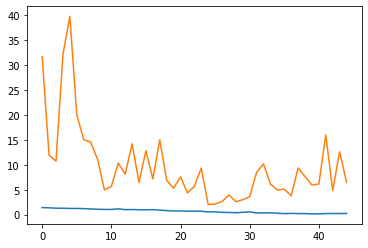

In [ ]:
tf.debugging.set_log_device_placement(True)

X_train, X_val, y_train, y_val = train_test_split(train_with_miss_no_ind, train_labels, test_size=0.15, random_state=147)


model = lsst_model(input_shape = (10,400,1), num_classes = 4)
# model = lsst_model(input_shape = (10,400,2), num_classes = 4)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001),
              loss=loss,
              metrics=['accuracy']
              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)

loss_hist = model.fit(X_train, y_train, epochs=500,
                       batch_size=10,
                       validation_data=(X_val, y_val),
                       callbacks=[reduce_lr,
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                mode='auto',
                                                verbose=0,
                                                patience=50,
                                                restore_best_weights=True)
                                  ]
                       )


import matplotlib.pyplot as plt

plt.plot(loss_hist.history['loss'])
plt.plot(loss_hist.history['val_loss'])


model.evaluate(test_with_miss_no_ind,  test_labels, verbose=2)